In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from urllib import request
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
import pickle

In [258]:
books=pd.read_csv('Books.csv', low_memory=False)
ratings=pd.read_csv('Ratings.csv')
users=pd.read_csv('Users.csv')

In [259]:
top_100=pickle.load(open('top_100.pkl', 'rb'))
top_100.head(2)

,Book-Title,Book-Author,Average_Rating,Image-URL-M
1,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,5.852804,http://images.amazon.com/images/P/0439136350.0...
2,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,5.824289,http://images.amazon.com/images/P/0439139597.0...


In [260]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [261]:
#Merge rating and books dataframe on "ISBN" number
books_rated=ratings.merge(books,on="ISBN")
books_rated.drop(columns=['Image-URL-S','Image-URL-L'],inplace=True)
books_rated.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...


In [262]:
books_rated=books_rated[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher','Image-URL-M', 'User-ID', 'Book-Rating']]
#books.drop_duplicates(inplace=True)
books_rated['Book-Title'].value_counts().head(3)

Wild Animus                  2502
The Lovely Bones: A Novel    1295
The Da Vinci Code             898
Name: Book-Title, dtype: int64

In [263]:
#Lets filter out some unpopular books by setting up a criteria

In [264]:
#count USER-IDs who have rated atleast 20 books, and saving those as experienced users

cond_1 = books_rated.groupby('User-ID').count()['Book-Rating']>=20
experienced_users= cond_1[cond_1].index

In [265]:
#filtering ratings based on criteria set on cond_1 i.e. users who have rated atleast 20 books

experienced_ratings=books_rated[books_rated['User-ID'].isin(experienced_users)]

In [266]:
#2nd condition is based on filtering the Books that have been rated by atleast 25 experienced Users (who have rated atleast 20 books)

cond_2 = experienced_ratings.groupby('Book-Title').count()['Book-Rating']>=25
interesting_books = cond_2[cond_2].index

In [268]:
#We have filtered out 4358 books that we can recommend to our users

interesting_books.shape

(4358,)

In [269]:
filtered_books = experienced_ratings[experienced_ratings['Book-Title'].isin(interesting_books)]

In [270]:
filtered_books.columns

Index(['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-M', 'User-ID', 'Book-Rating'],
      dtype='object')

In [271]:
filtered_books=filtered_books[['Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-M']]

In [272]:
filtered_books.drop_duplicates(subset=['Book-Title'],inplace=True)
filtered_books['Book-Title'].value_counts().head(3)

Flesh Tones: A Novel                                 1
The Grilling Season                                  1
All the Pretty Horses (The Border Trilogy, Vol 1)    1
Name: Book-Title, dtype: int64

In [273]:
filtered_books.isna().sum()

Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-M            0
dtype: int64

In [274]:
#Join full words together, so that our machine doesn't get confused

filtered_books['Book-Author'] = filtered_books['Book-Author'].apply(lambda x: x.replace(" ",""))
filtered_books['Publisher'] = filtered_books['Publisher'].apply(lambda x: x.replace(" ",""))

In [275]:
filtered_books.head()

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M
1,Flesh Tones: A Novel,M.J.Rose,2002,BallantineBooks,http://images.amazon.com/images/P/034545104X.0...
63,The Notebook,NicholasSparks,1996,WarnerBooks,http://images.amazon.com/images/P/0446520802.0...
184,A Painted House,JOHNGRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...
368,Lightning,DeanR.Koontz,1996,BerkleyPublishingGroup,http://images.amazon.com/images/P/0425115801.0...
502,Manhattan Hunt Club,JOHNSAUL,2002,BallantineBooks,http://images.amazon.com/images/P/0449006522.0...


In [276]:
#Now creating a tag representation of a book
filtered_books['tags']=filtered_books['Book-Author']+[" "]+filtered_books['Year-Of-Publication']+[" "]+filtered_books['Publisher']

In [277]:
filtered_books.head(3)

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-M,tags
1,Flesh Tones: A Novel,M.J.Rose,2002,BallantineBooks,http://images.amazon.com/images/P/034545104X.0...,M.J.Rose 2002 BallantineBooks
63,The Notebook,NicholasSparks,1996,WarnerBooks,http://images.amazon.com/images/P/0446520802.0...,NicholasSparks 1996 WarnerBooks
184,A Painted House,JOHNGRISHAM,2001,Doubleday,http://images.amazon.com/images/P/038550120X.0...,JOHNGRISHAM 2001 Doubleday


In [278]:
filtered_books=filtered_books[['Book-Title','tags','Image-URL-M']]

In [279]:
filtered_books.head(3)

,Book-Title,tags,Image-URL-M
1,Flesh Tones: A Novel,M.J.Rose 2002 BallantineBooks,http://images.amazon.com/images/P/034545104X.0...
63,The Notebook,NicholasSparks 1996 WarnerBooks,http://images.amazon.com/images/P/0446520802.0...
184,A Painted House,JOHNGRISHAM 2001 Doubleday,http://images.amazon.com/images/P/038550120X.0...


In [286]:
books_matrix=filtered_books
books_matrix.shape
books_matrix.index=range(0,4358)

In [287]:
#Creates word vector, excluding words like 'is, the....'
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(books_matrix['tags']).toarray()

In [288]:
vector.shape

(4358, 2016)

In [289]:

similarity = cosine_similarity(vector)
similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [290]:
#Recommender Function
book_list=[]

def recommend(book_name):
    
    try:
        index = books_matrix[books_matrix['Book-Title'] == book_name].index[0]
        dis = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])

        for i in dis[1:6]:

            book_list.append((books_matrix.iloc[i[0]]['Book-Title'],books_matrix.iloc[i[0]]['Image-URL-M']))

        return book_list

    
    except IndexError:

    #If error generated above, function will return False
        return False



In [291]:
book_name='The Notebook'

In [292]:
recommended_books=recommend(book_name)

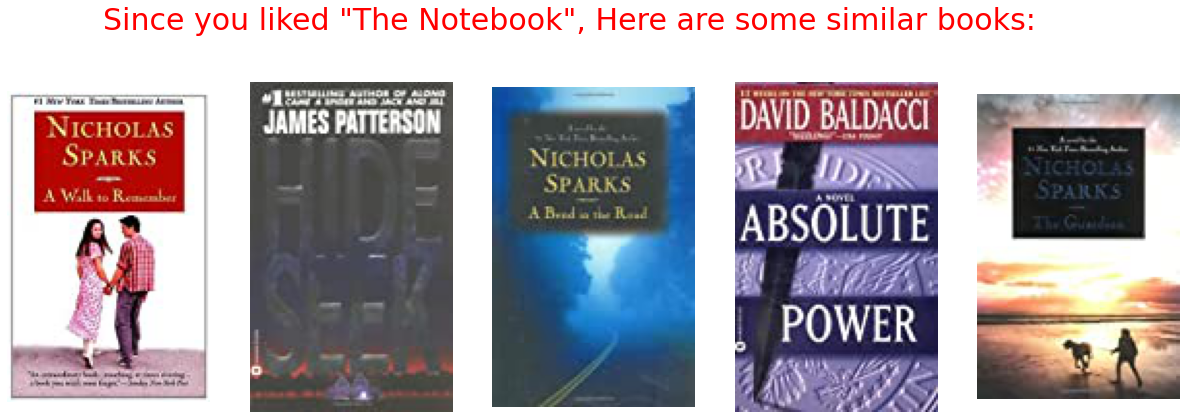

In [293]:
#Error handling in case of Book not in highly rated books, we show 10 most popular books!
if recommended_books == False:

    fig,ax=plt.subplots(1,10,figsize=(20,4))
    fig.suptitle(f"You might Like from our Top 10 Books: ",fontsize=30, color='red')

    for x in range(10):

        request.urlretrieve(top_100[0:10]['Image-URL-M'].values[x], "sample.jpg")
        ax[x].imshow(Image.open("sample.jpg"))
        ax[x].axis('off')


#If book name is in filtered matrix
else:    
    fig,ax=plt.subplots(1,5,figsize=(21,7))
    fig.suptitle(f"Since you liked \"{book_name}\", Here are some similar books: ",fontsize=30, color='red')

    for i in range(len(recommended_books)):

        request.urlretrieve(recommended_books[i][1], "sample.jpg")
        ax[i].imshow(Image.open("sample.jpg"))
        ax[i].axis('off')

In [ ]:
#We can see that it has recommended more books of Nicholas Sparks since Notebook is also written by Nicholas Sparks
#Content based filtering would have worked better, if we had Genre and bit of Book description as well
#In the dataset provided it just performs average